<a href="https://colab.research.google.com/github/violafjrnnn/ml-model-example/blob/main/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"violafajrin","key":"b40aaaf4aef9c0a827ede12dece1a402"}'}

In [ ]:
#mengubah akses file kaggle kredensial
!mv kaggle.json ~/.kaggle/

In [ ]:
#import dataset ke dalam folder konten
!kaggle datasets download -d niten19/face-shape-dataset

 98% 625M/639M [00:06<00:00, 127MB/s]
100% 639M/639M [00:06<00:00, 99.5MB/s]


In [ ]:
#mengeskstrak file dataset

import zipfile
zip_file = zipfile.ZipFile('/content/face-shape-dataset.zip')
zip_file.extractall('/tmp/')

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#mengimport ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import h5py
from PIL import Image
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras import backend as K
import numpy as np

In [ ]:
batch_size = 16  #was 16
train_images = '../tmp/FaceShape Dataset/training_set'
test_images = '../tmp/FaceShape Dataset/testing_set'

TrainDatagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        horizontal_flip = True,
        vertical_flip=True
)

TestDatagen = ImageDataGenerator(
    preprocessing_function= preprocess_input

)

train_data = TrainDatagen.flow_from_directory(
    train_images,
    target_size = (224,224),
    batch_size =batch_size,
    class_mode = 'categorical'


)

test_data = TestDatagen.flow_from_directory(
    test_images,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5,min_delta= .05, monitor="val_accuracy")
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
    train_data,
    steps_per_epoch = train_data.samples//batch_size,
    validation_data = test_data,
    validation_steps = test_data.samples//batch_size,
    epochs = 50,
)
model.save("test.h5")

<ipython-input-12-5c4e98390a8d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
250/250 [==============================] - 95s 331ms/step - loss: 1.6098 - accuracy: 0.2040 - val_loss: 1.6096 - val_accuracy: 0.2006
Epoch 2/50
250/250 [==============================] - 83s 332ms/step - loss: 1.6041 - accuracy: 0.2265 - val_loss: 1.6077 - val_accuracy: 0.2651
Epoch 3/50
250/250 [==============================] - 83s 333ms/step - loss: 1.5769 - accuracy: 0.2603 - val_loss: 1.5653 - val_accuracy: 0.2964
Epoch 4/50
250/250 [==============================] - 83s 331ms/step - loss: 1.5409 - accuracy: 0.2860 - val_loss: 1.5016 - val_accuracy: 0.3427
Epoch 5/50
250/250 [==============================] - 83s 333ms/step - loss: 1.5039 - accuracy: 0.3192 - val_loss: 1.4670 - val_accuracy: 0.3377
Epoch 6/50
250/250 [==============================] - 76s 301ms/step - loss: 1.4552 - accuracy: 0.3455 - val_loss: 1.5168 - val_accuracy: 0.3226
Epoch 7/50
250/250 [==============================] - 83s 330ms/step - loss: 1.4191 - accuracy: 0.3672 - val_loss: 1.3982 - val_ac

In [ ]:
import tensorflow as tf
print('Tensorflow version : ',tf.__version__)
!pip install tensorflowjs

Tensorflow version :  2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20

In [ ]:
os.listdir('/tmp/FaceShape Dataset/training_set')

['Oblong', 'Oval', 'desktop.ini', 'Round', 'Square', 'Heart']

In [ ]:
test_data.class_indices

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

Saving WhatsApp Image 2023-06-10 at 01.02.35.jpg to WhatsApp Image 2023-06-10 at 01.02.35.jpg
1/1 [==============================] - 0s 19ms/step
Square


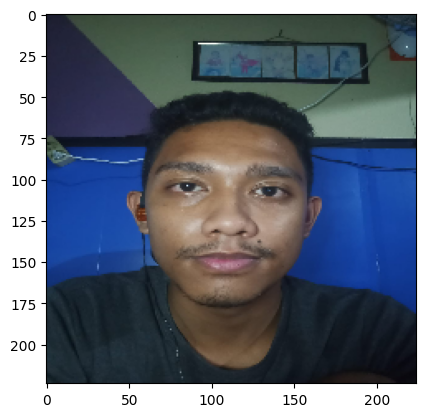

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
# # keras preprocessing sudah deprecated di versi 2.9.2
from tensorflow.keras import utils as image
# # maka saya menggunakan cara diatas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img_source = image.load_img(path, target_size = (224,224))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  answer = np.argmax(classes, axis = 1)

  if answer[0] == 0:
    print('Heart')
  elif answer[0] == 1:
    print('Oblong')
  elif answer[0] == 2:
    print('Oval')
  elif answer[0] == 3:
    print('Round')
  elif answer[0] == 4:
    print('Square')


In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.model
!tensorflowjs_converter --input_format keras test.h5 model/

2023-06-09 18:05:14.631386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r hairfit.zip model/

  adding: model/ (stored 0%)
  adding: model/group1-shard91of100.bin (deflated 8%)
  adding: model/group1-shard90of100.bin (deflated 8%)
  adding: model/group1-shard29of100.bin (deflated 8%)
  adding: model/group1-shard99of100.bin (deflated 8%)
  adding: model/group1-shard7of100.bin (deflated 8%)
  adding: model/group1-shard65of100.bin (deflated 8%)
  adding: model/group1-shard31of100.bin (deflated 8%)
  adding: model/group1-shard50of100.bin (deflated 8%)
  adding: model/group1-shard55of100.bin (deflated 8%)
  adding: model/group1-shard62of100.bin (deflated 8%)
  adding: model/group1-shard83of100.bin (deflated 8%)
  adding: model/group1-shard28of100.bin (deflated 8%)
  adding: model/group1-shard44of100.bin (deflated 8%)
  adding: model/group1-shard64of100.bin (deflated 8%)
  adding: model/group1-shard22of100.bin (deflated 8%)
  adding: model/group1-shard69of100.bin (deflated 8%)
  adding: model/group1-shard20of100.bin (deflated 8%)
  adding: model/group1-shard70of100.bin (deflated 8%)
